In [1]:
import math
import copy 
import tqdm
import time
import torch
import gpytorch
import pickle 
import itertools 
import warnings
import scipy
import scipy.sparse.linalg
from collections import defaultdict, OrderedDict

from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML
from IPython.display import clear_output

import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "~/skisg/"
sys.path.append(os.environ['PRJ'])

random.seed(1337)
np.random.seed(1337)

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/gj/ns_zjdqx57b1mrqf3l8_rcd40000gp/T/ipykernel_98266/3119918860.py:15: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix


In [8]:
from skisg.interp.sparse.construct import G
from skisg.interp.rectgrid import get_basis, grid_points
from skisg.config import SgBasisType, InterpType
from skisg.interp.sparse.combination import spinterpolate

In [9]:
## Defining simple functoins 

bj = np.array([9.0, 7.25, 1.85, 7.03, 20.4, 4.3, 1.0, 1.0])

# ocillatory 
f_osc = lambda X, w, c : np.cos(np.pi*2*w[0] + np.matmul(X, c))

# product peak 
f_product = lambda X, w, c : np.prod((1/(c**(-2) + (X - w)**2)), axis=1)

# corner peak 
f_corner = lambda X, w, c: (1 + np.matmul(X, c))**(- X.shape[1] - 1)

# guassian peak 
f_gaussian = lambda X, w, c: np.exp(-np.sum((c**2)*(X - w)**2, axis=1))

# continuous peak 
f_continuous = lambda X, w, c: np.exp(- np.sum(c*(np.abs(X- w)), axis=1))

#  
f_sine2 = lambda X, w, c: np.sin(np.sum(X, axis=1))


# dis-continuous peak 
def f_discontinuous(X, w, c):
    vals = np.exp(np.sum(X*c, axis=1))
    zeros = np.logical_or(X[:, 0] > w[0], X[:, 1] > w[1])
    vals[zeros] = 0 
    return vals 

# checkorboard 
f_check = lambda X, w, c:  np.sin(4*np.pi*(X[:, 0] + X[:, 1]))

    
def get_cj(i, ndim):
    i = i-1
    tt = np.random.rand(ndim)
    return bj[i]*tt/np.sum(tt)

In [10]:

def err(f1, f2):
    return np.mean(np.abs(f1-f2))

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def run_experiment(task_id=1, kind='linear', ndim=2, ml=9):

    ntest = 200
    Xtest = np.random.rand(ntest, ndim)
    umin = -0.1
    umax = 1.1
        
    funcs = {1:f_osc, 2:f_product, 3: f_corner, 4: f_gaussian, 5: f_continuous, 
             6: f_discontinuous, 7: f_check, 8:f_sine2}
    func = funcs[task_id]
        
    print("Function: ", namestr(funcs[task_id], globals()))
    c = get_cj(task_id, ndim)
    w = np.random.rand(ndim)
    f_t = func(Xtest, w, c)

    rg_methods = defaultdict(list)
    sg_methods = defaultdict(list)  
    sg_func = lambda x: func(x, w, c)
    
    
    for gl in tqdm.tqdm(range(2, ml)):

        # sparse-grid 
        for kind in [0, 1]:
            for basis in [0, 1, 2, 3]:
                f_h, numpoints = spinterpolate(sg_func, Xtest, gl, ndim, umin, umax, kind=InterpType(kind), basis=SgBasisType(basis))            
                sg_error = err(f_h, f_t),
                sg_methods[(kind, basis)] += (sg_error, numpoints),

        # regular-grid 
        grid_size_dim = int(np.floor(G(gl, ndim)**(1/ndim)))
        grid = [(umin, umax, grid_size_dim)]*ndim
        X = grid_points(grid)
        f_rg = func(X, w, c)
        
        # regular-grid-interpolation
        W = get_basis(Xtest, grid, kind='linear')
        f_h = (W@f_rg.reshape(-1, 1)).reshape(-1)
        rg_methods['linear'] += (err(f_h, f_t), X.shape[0]),

        W = get_basis(Xtest, grid, kind='cubic')
        f_h = (W@f_rg.reshape(-1, 1)).reshape(-1)
        rg_methods['cubic'] += (err(f_h, f_t), X.shape[0]),
        
    return sg_methods, rg_methods

def plt_figure(sg_methods, rg_methods):

    plt.figure(figsize=(15, 10))

    for kind in [0, 1]:
        for basis in [0, 1, 2, 3]:
            label = 'SG (' +  ('linear' if kind == 0 else 'cubic') + '+ '
            if basis == 0:
                label += ' naive)'
            elif basis == 1:
                label += ' modified)'
            elif basis == 2:
                label += ' const)'
            elif basis == 3:
                label += ' bound)'    

            sg_sizes = [i[1] for i in sg_methods[(kind, basis)]]
            sg_errors = [i[0] for i in sg_methods[(kind, basis)]]
            plt.plot(sg_sizes, sg_errors, '+-' if 'cubic' in label else 'o-', label=label)

    plt.plot([i[1] for i in rg_methods['linear']], [i[0] for i in rg_methods['linear']],  'o-', label='RG (linear)')
    plt.plot([i[1] for i in rg_methods['cubic']], [i[0] for i in rg_methods['cubic']], '+-', label='RG (cubic)')
    plt.legend(loc="lower left")
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Error')
    plt.xlabel('Grid size')
    plt.show()

Function:  f_osc


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.93it/s]


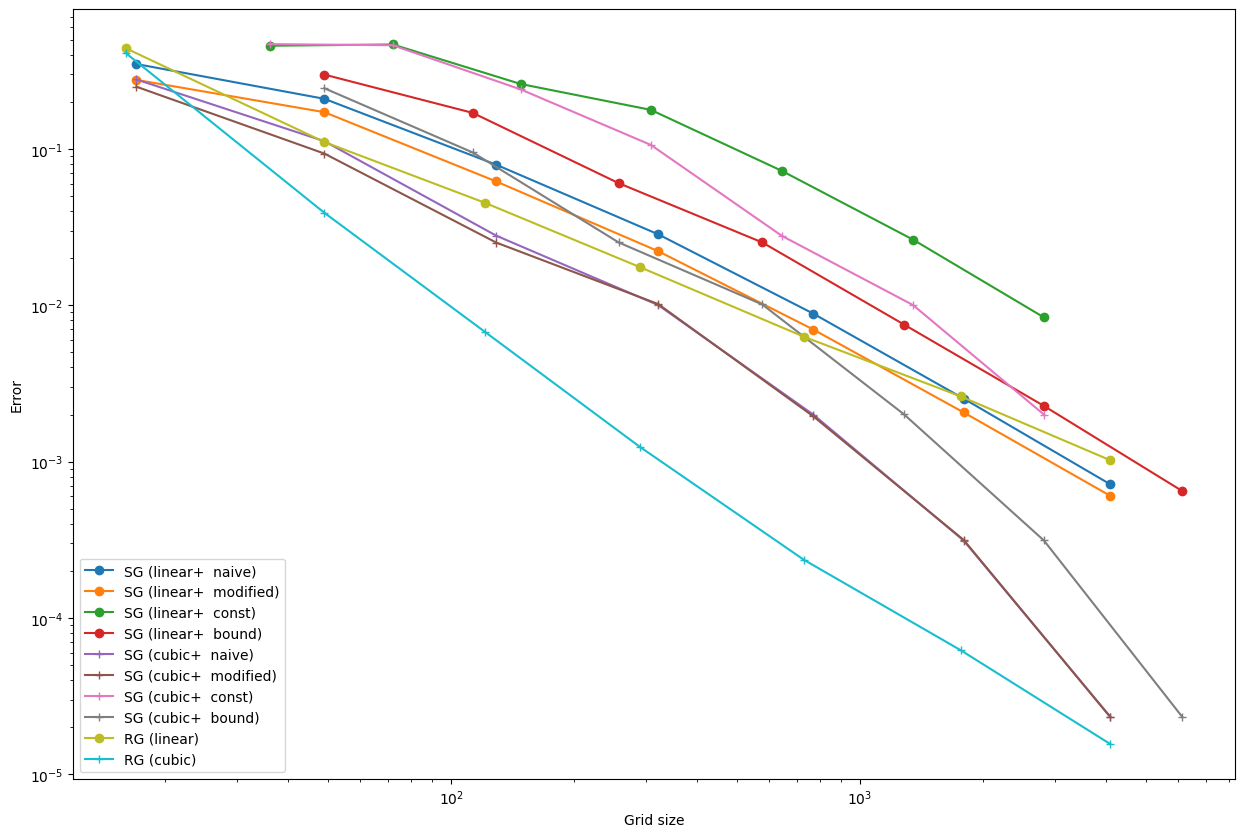

Function:  f_product


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.65it/s]


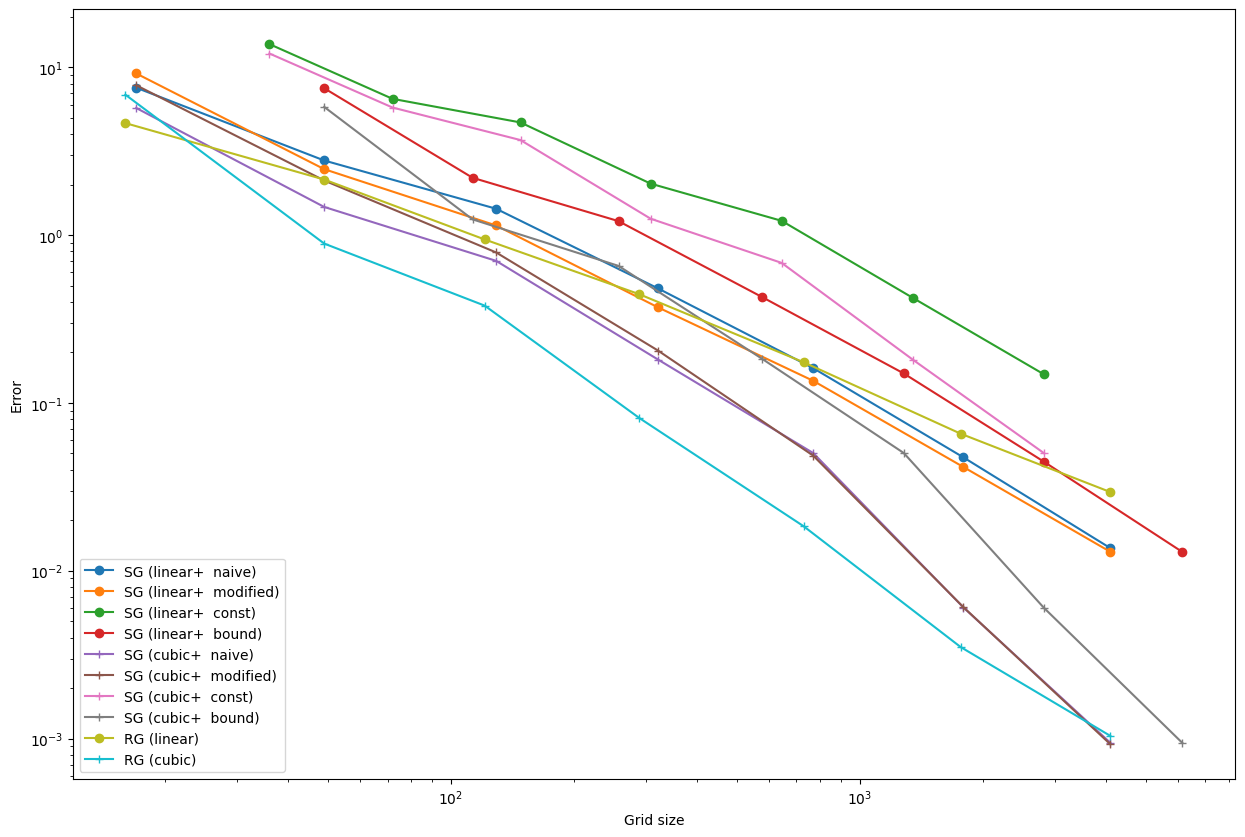

Function:  f_corner


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.80it/s]


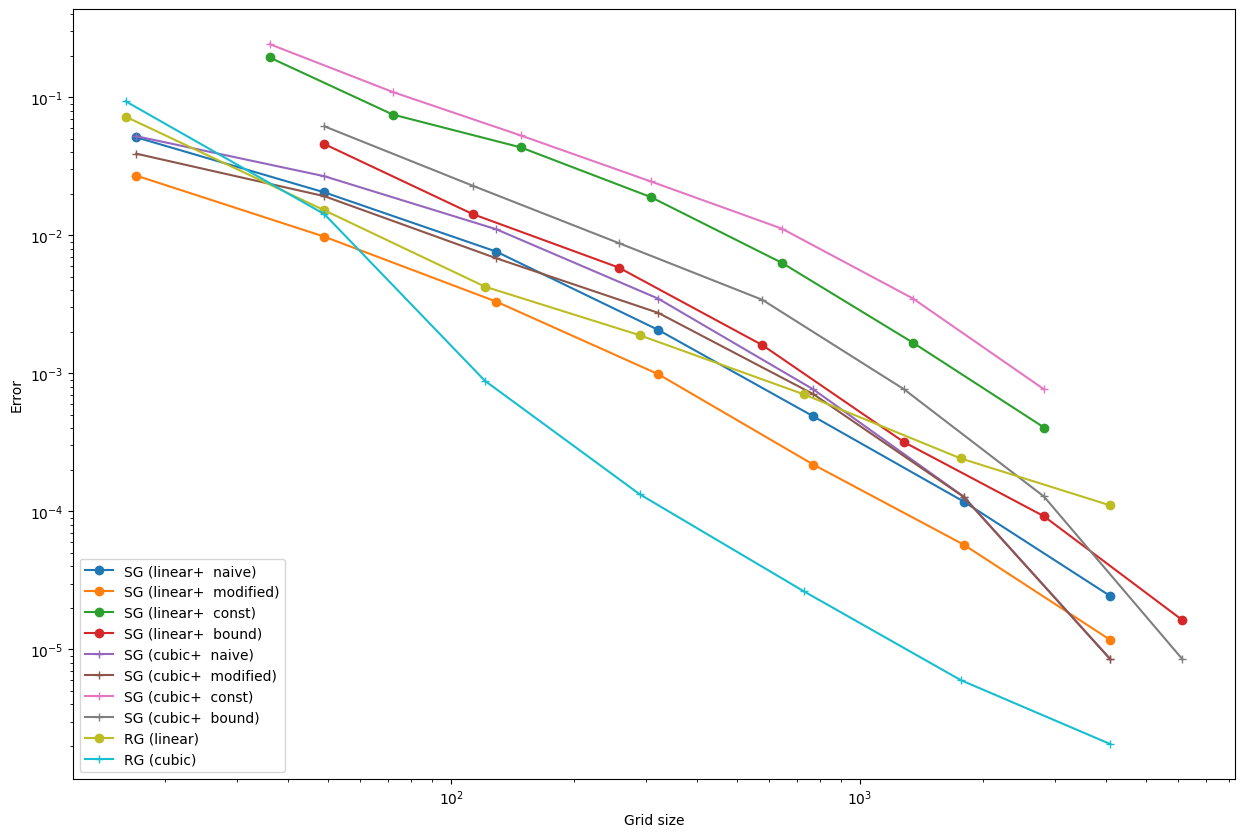

Function:  f_gaussian


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.30it/s]


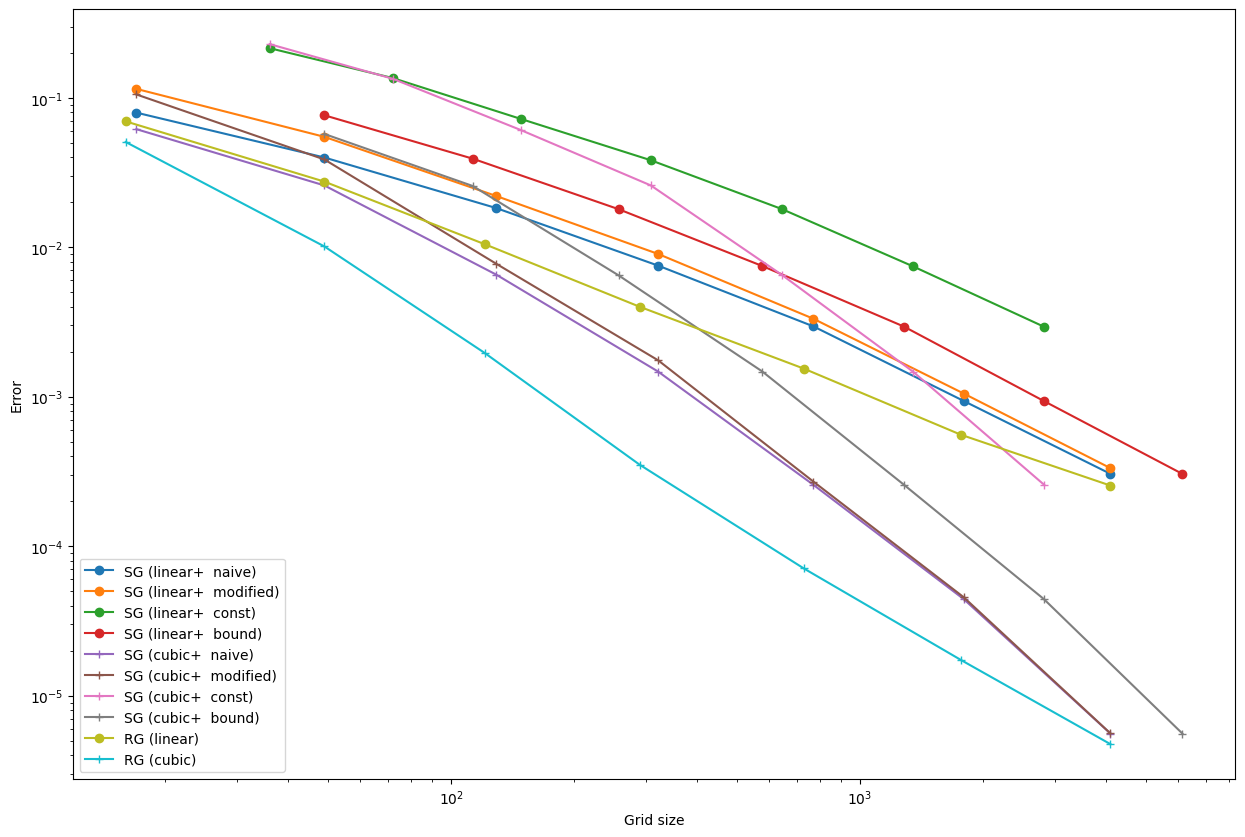

CPU times: user 9.74 s, sys: 975 ms, total: 10.7 s
Wall time: 9.32 s


In [11]:
%%time 

ndim = 2
for task in [1, 2, 3, 4]:
    plt_figure(*run_experiment(task_id=task, ndim=2))

Function:  f_osc


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]


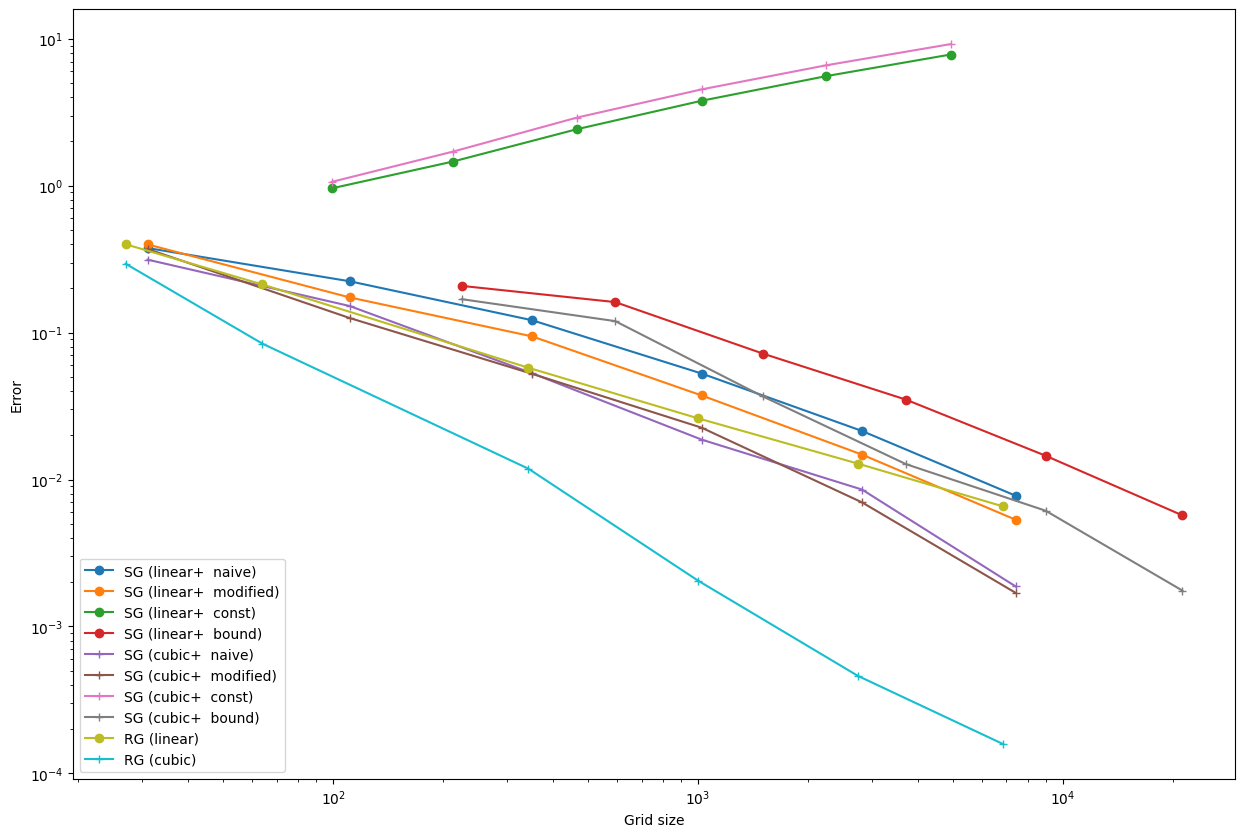

Function:  f_product


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


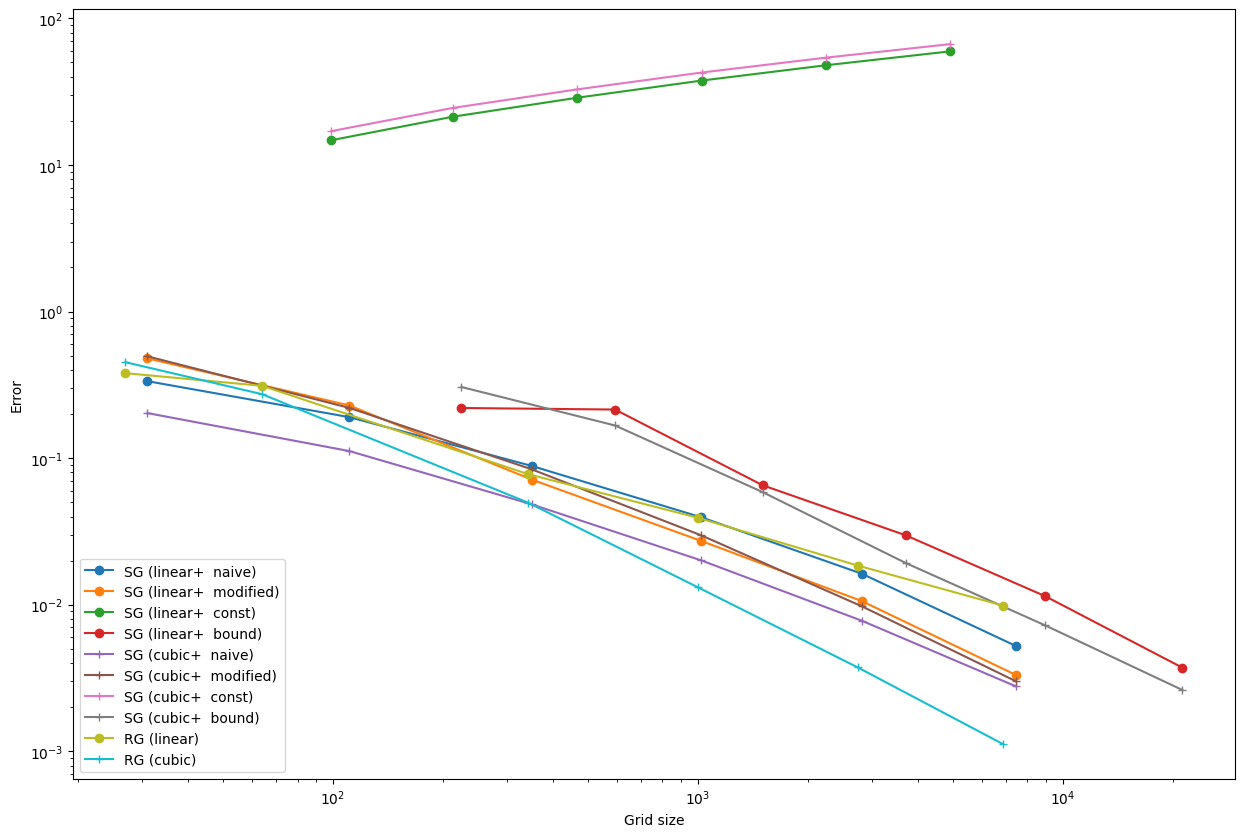

Function:  f_corner


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]


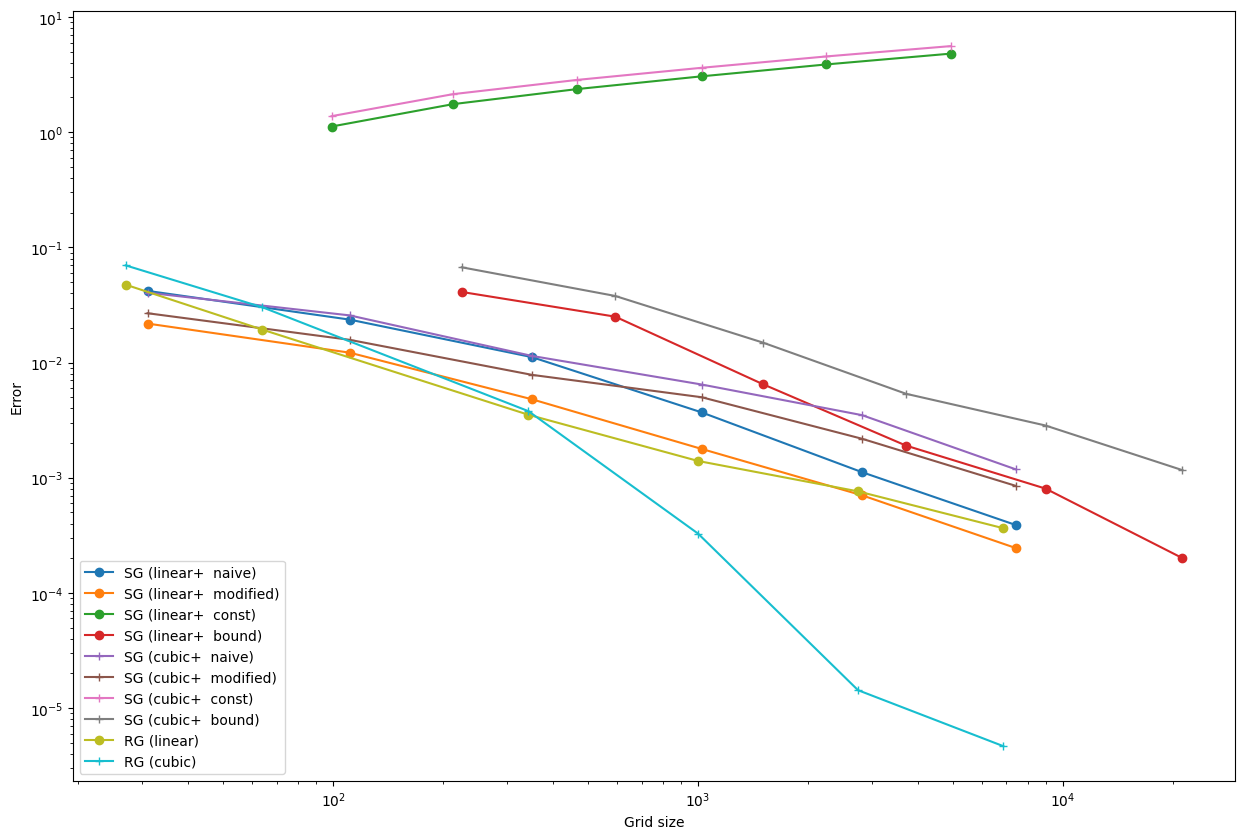

Function:  f_gaussian


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]


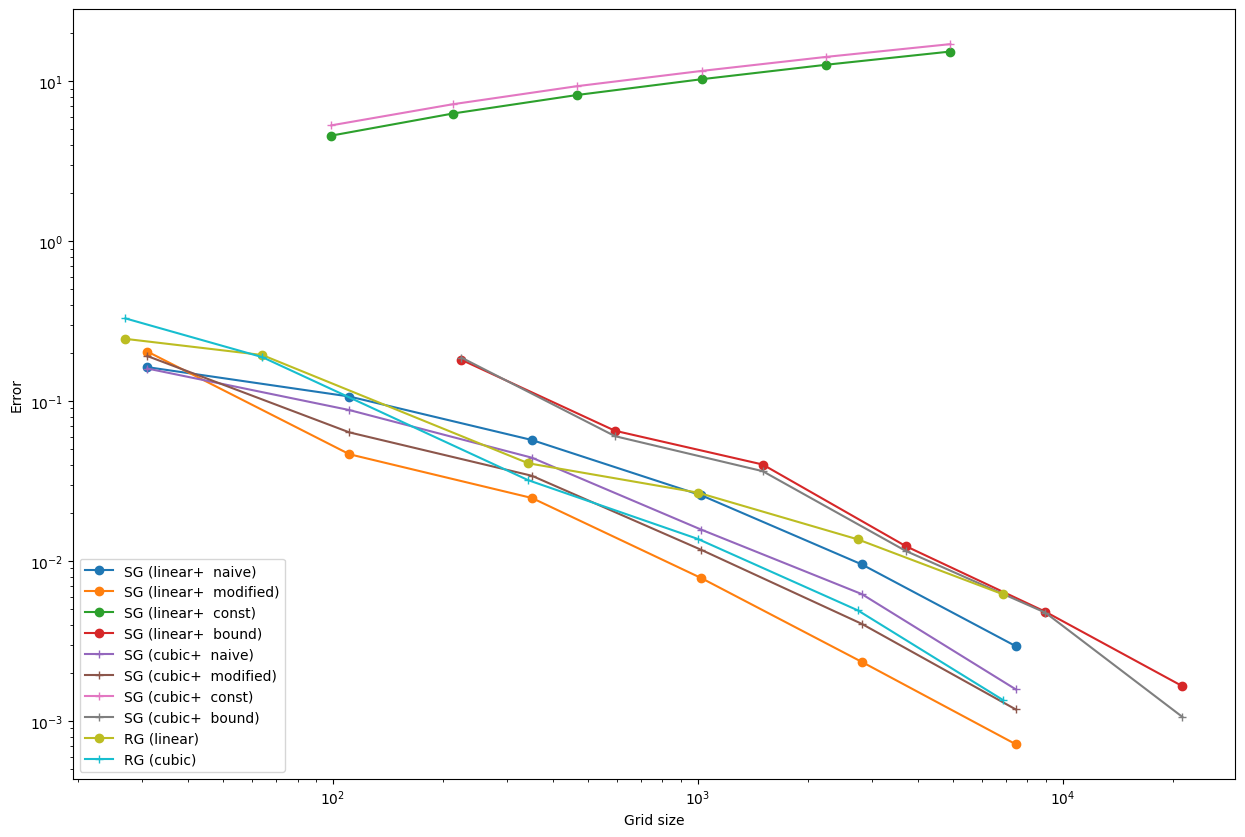

CPU times: user 25 s, sys: 3.36 s, total: 28.3 s
Wall time: 22.1 s


In [12]:
%%time 

for task in [1, 2, 3, 4]:
    plt_figure(*run_experiment(task_id=task, ndim=3, ml=8))

Function:  f_sine2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


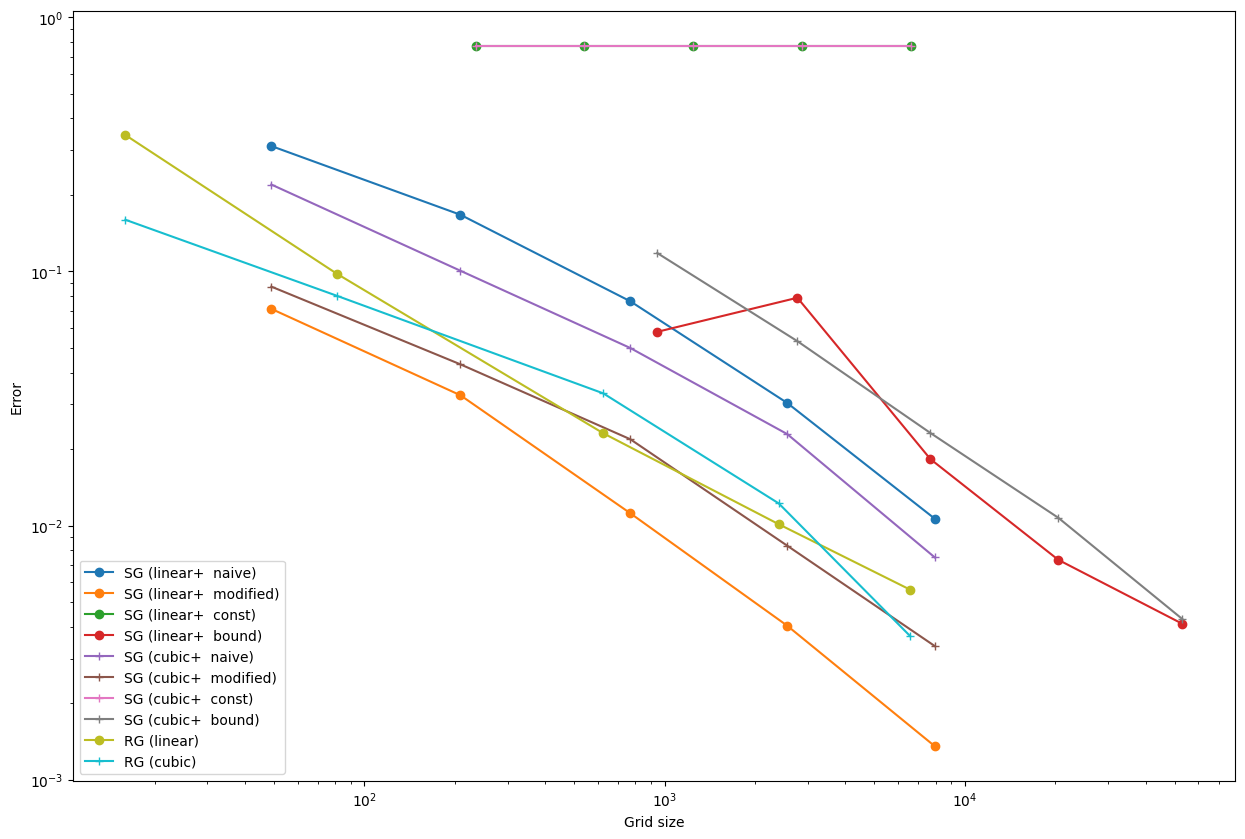

CPU times: user 9.75 s, sys: 507 ms, total: 10.3 s
Wall time: 10.3 s


In [13]:
%%time 
# ndim = 4
for task in [8]:
    plt_figure(*run_experiment(task_id=task, ndim=4, ml=7))